In [12]:
import torch
from torch import nn, optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm


%matplotlib inline

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [14]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p = 0.7
N = 10000

batch_size = 100
num_epoches = 250
z_dim = 2

In [15]:
c = torch.distributions.Bernoulli(p). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [16]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

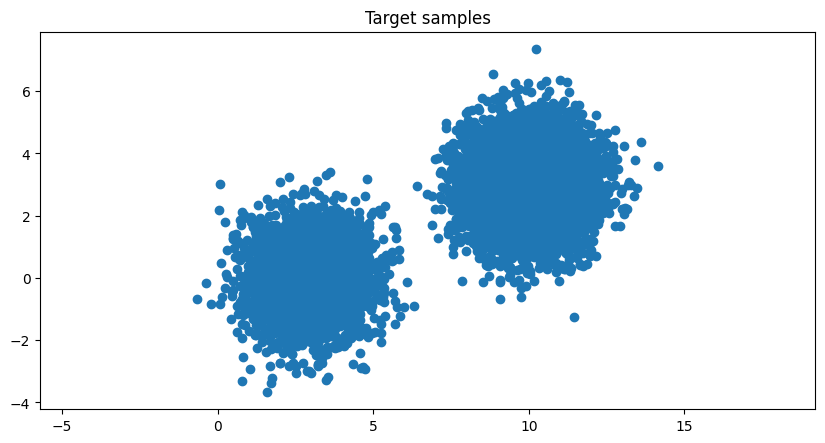

In [17]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [18]:
class VAE_stand_prior(nn.Module):
  def __init__(self):
    super(VAE_stand_prior, self).__init__()

    self.fc0 = nn.Linear(2, 5) # for encoder
    self.fc1 = nn.Linear(5, 10)
    self.fc2 = nn.Linear(10, z_dim) 
    self.fc3 = nn.Linear(10, z_dim)

    self.fc4 = nn.Linear(z_dim, 10) # for decoder
    self.fc5 = nn.Linear(10, 5)
    self.fc6 = nn.Linear(5, 2)

  def encode(self, x):
    h = torch.relu(self.fc0(x))
    g = torch.relu(self.fc1(h))
    return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    h = torch.relu(self.fc4(z))
    g = torch.relu(self.fc5(h))
    return self.fc6(g) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    return self.decode(z), mu, logvar

In [19]:
model = VAE_stand_prior().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [20]:
def loss_function(x, mu_0, mu, logvar):
    KL = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()) # KL-divergence
    distr = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
    ELH = distr.log_prob(x) # 1-MC approximation of expected log likelihood
    return KL.mean() - ELH.mean()

In [21]:
dataloader = DataLoader(X, batch_size=batch_size, shuffle=True, )

In [22]:
for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 50 == 0:
        print(loss.cpu().detach().numpy())

  0%|          | 1/250 [00:00<01:37,  2.55it/s]

40.986897


 20%|██        | 51/250 [00:14<00:54,  3.67it/s]

2.741663


 40%|████      | 101/250 [00:27<00:41,  3.62it/s]

2.7143152


 60%|██████    | 151/250 [00:41<00:27,  3.58it/s]

2.6749997


 80%|████████  | 201/250 [00:55<00:13,  3.67it/s]

2.696123


100%|██████████| 250/250 [01:09<00:00,  3.62it/s]


##Generation

In [23]:
prior = torch.distributions.normal.Normal(torch.tensor(0., device=device, dtype=torch.float32),
                                          torch.tensor(1., device=device, dtype=torch.float32),)

In [24]:
pr_samples = prior.sample((1000, z_dim))

In [25]:
mu_0 = model.decode(pr_samples).detach().cpu()

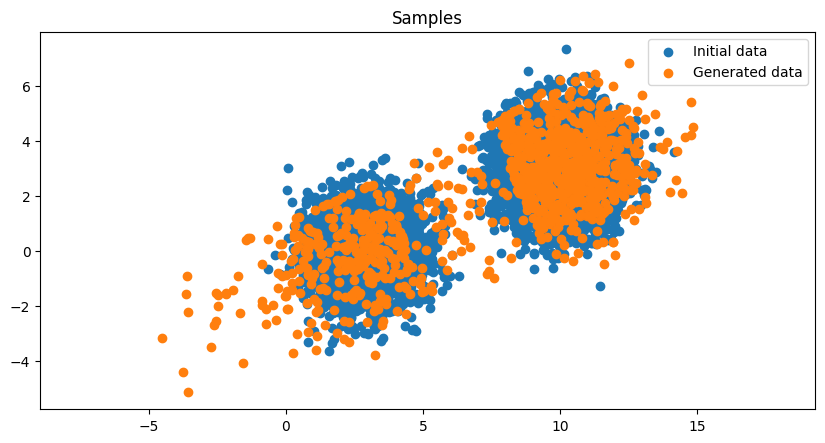

In [26]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], label='Initial data')
plt.scatter(mu_0[:, 0], mu_0[:, 1], label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

No handles with labels found to put in legend.


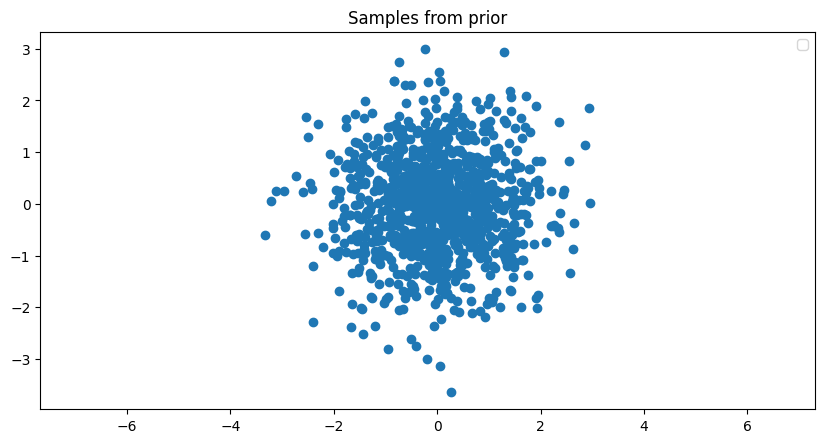

In [27]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [28]:
X_rec = model(X) #reconstructed data

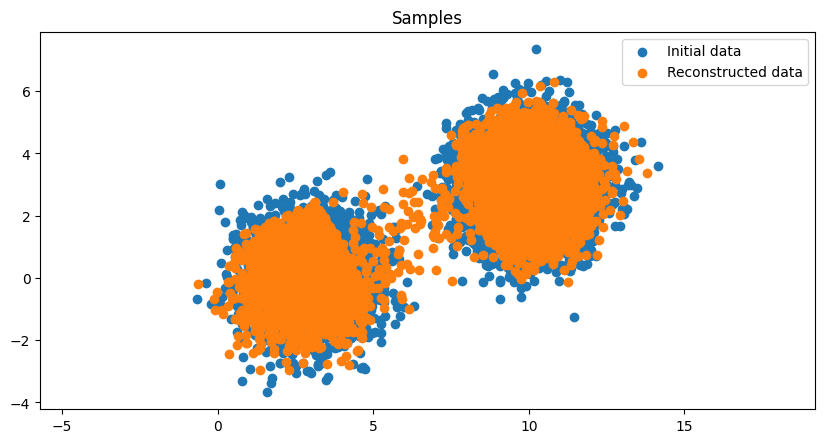

In [29]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

## Latent space illustration

In [30]:
mu_1, logvar_1 = model.encode(Y[Y[:, 2] == 0, 0:2])
mu_2, logvar_2 = model.encode(Y[Y[:, 2] == 1, 0:2])

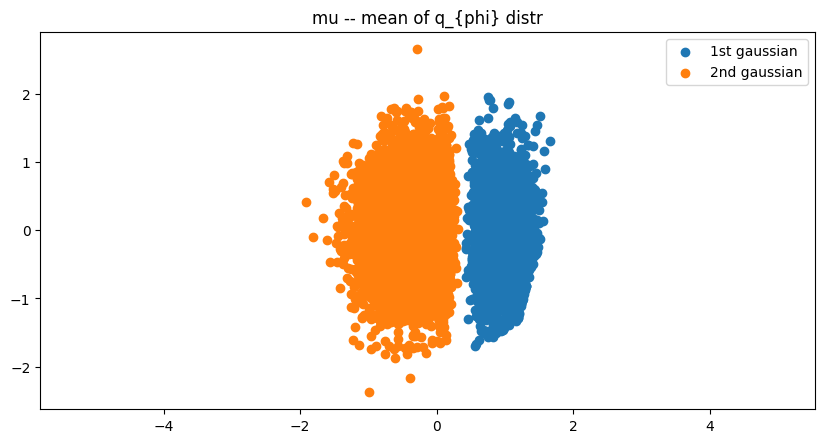

In [31]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu -- mean of q_{phi} distr')
plt.scatter(mu_1[:, 0].detach().cpu(), mu_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(mu_2[:, 0].detach().cpu(), mu_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();

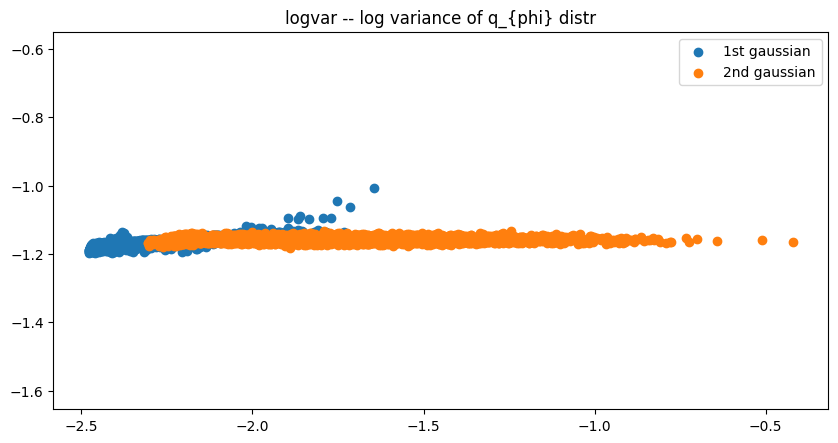

In [32]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar -- log variance of q_{phi} distr')
plt.scatter(logvar_1[:, 0].detach().cpu(), logvar_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(logvar_2[:, 0].detach().cpu(), logvar_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();